# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path


In [2]:
def downcastMemoryUsage(dataFrame):
    startMemoryOptimization = dataFrame.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is: {:.2f} MB'.format(startMemoryOptimization))
    subTypeInt = ['uint8','uint16','uint32','uint64','int8','int16','int32','int64']
    subTypeFloat = ['float16','float32','float64']
    for column in dataFrame.columns:
        columnType = str(dataFrame[column].dtypes)
        maximumColumn = dataFrame[column].max()
        minimumColumn = dataFrame[column].min()
        if 'int' in columnType:
            for element in subTypeInt:
                if minimumColumn > np.iinfo(element).min and maximumColumn < np.iinfo(element).max:
                    dataFrame[column] = dataFrame[column].astype(element)
                    break
        elif 'float' in columnType:
            for element in subTypeFloat:
                if minimumColumn > np.finfo(element).min and maximumColumn < np.finfo(element).max:
                    dataFrame[column] = dataFrame[column].astype(element)
                    break
        elif 'object' in columnType:
            if column =='date':
                dataFrame['date'] = pd.to_datetime(dataFrame['date'],format='%Y-%m-%d')
            else:
                numberOfUnique = len(dataFrame[column].unique())
                numberOfTotal = len(dataFrame[column])
                if numberOfUnique / numberOfTotal < 0.5:
                    dataFrame[column] = dataFrame[column].astype('category')
    endMemoryOptimization = dataFrame.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(endMemoryOptimization))
    print('Compressed by: {:.2f} %'.format(100*(startMemoryOptimization - endMemoryOptimization) / startMemoryOptimization))
    
    return dataFrame

In [3]:
def candelstick_chart(data,title):
    candlestick = go.Figure(data = [go.Candlestick(x =data.index, 
                                               open = data[('Open')], 
                                               high = data[('High')], 
                                               low = data[('Low')], 
                                               close = data[('Close')])])
    candlestick.update_xaxes(title_text = 'Time',
                             rangeslider_visible = True)

    candlestick.update_layout(
    title = {
        'text': '{:} Candelstick Chart'.format(title),
        'y':0.90,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    candlestick.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    return candlestick

In [4]:
if "jupyter" in str(Path().absolute()):
    path = "/home/jupyter/G-Research-Crypto/00_Data/"
    print('Running Locally')
else:
    path = "../input/g-research-crypto-forecasting/"
    print('Running on Kaggle')

Running on Kaggle


# Load Data + DownCast

In [5]:
train = pd.read_csv(path + 'train.csv') 
train['DateAndTime'] = pd.to_datetime(train['timestamp'], unit='s',utc = True,infer_datetime_format = True,)
train['Date'] = train.DateAndTime.dt.date
train['Date'] = train['Date'].astype('datetime64[ns]')
train.set_index(['DateAndTime'], inplace=True)
asset_details = pd.read_csv(path + 'asset_details.csv') 

In [6]:
# downcastMemoryUsage(train)

# Visualization

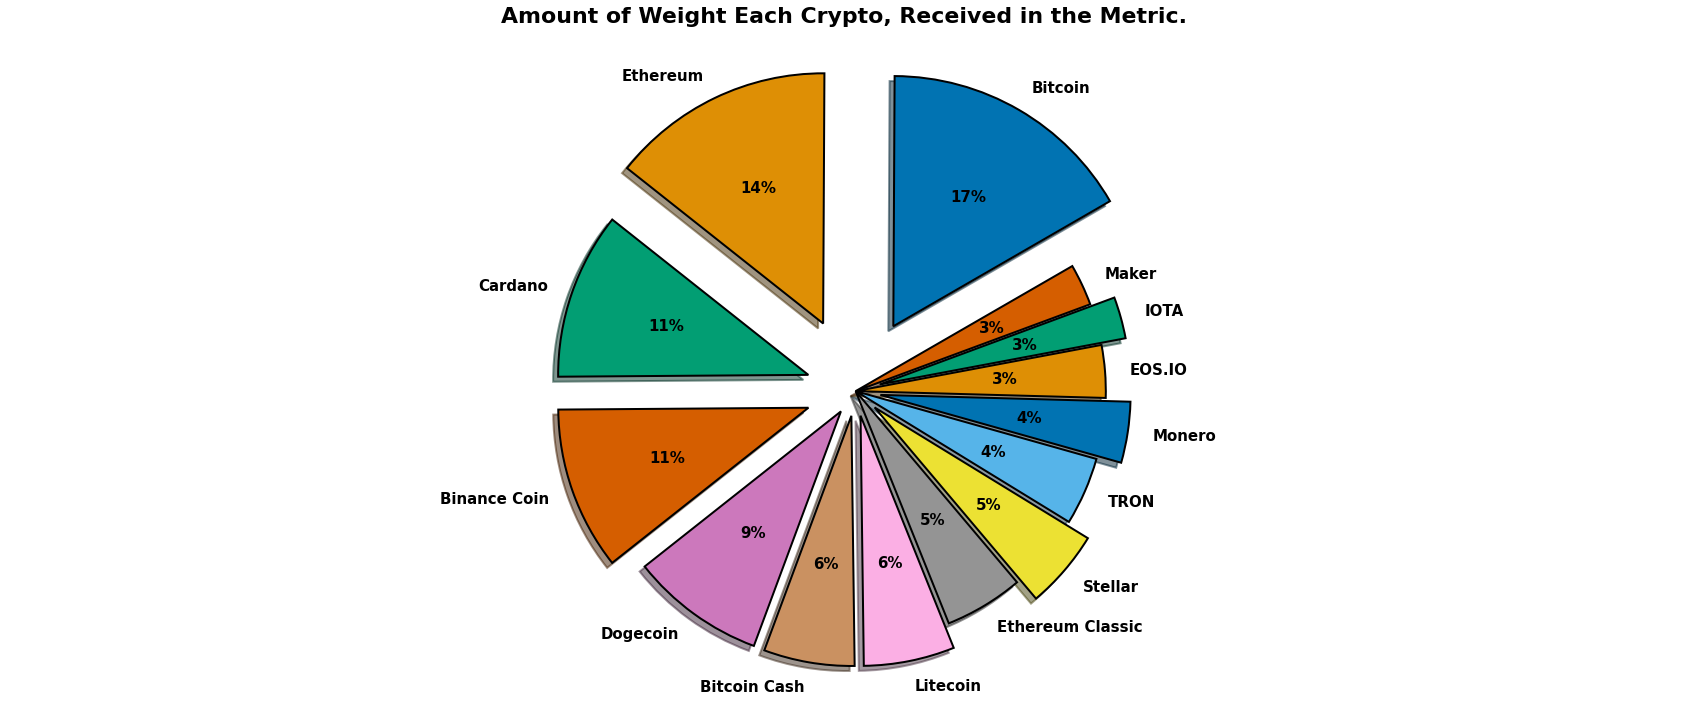

In [7]:
asset_details.sort_values(by=['Weight'],ascending=False,inplace=True)
# df[percent] = (df['column_name'] / df['column_name'].sum()) * 100
asset_details['coinWeightPercent'] = (asset_details['Weight'] / asset_details['Weight'].sum()) * 100
asset_details

fig = plt.figure()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 5, box.height * 3])
colors = sns.color_palette('colorblind')[0:14]
labels = ['Bitcoin', 'Ethereum', 'Cardano', 'Binance Coin', 'Dogecoin', 'Bitcoin Cash', 'Litecoin', 'Ethereum Classic',
          'Stellar', 'TRON', 'Monero', 'EOS.IO', 'IOTA', 'Maker']
explode = (0.3, 0.3, 0.2, 0.2, 0.1, 0.1, 0.1, 0.0, 0.1, 0.0, 0.1, 0.0, 0.1, 0.0)
plt.pie(asset_details['coinWeightPercent'], colors=colors, autopct='%.0f%%', labels=labels, explode=explode,
        startangle=30, shadow=True, textprops={'fontweight': 'semibold', 'fontsize': 15},
        wedgeprops={'linewidth': 2, 'edgecolor': 'k'}, labeldistance=1.1)
plt.title("Amount of Weight Each Crypto, Received in the Metric.", fontweight="bold", fontsize=22, pad=21)
plt.axis('equal')
plt.show()

In [8]:
asset_count= []
for i in range(14):
    count = (train["Asset_ID"]==i).sum()
    asset_count.append(count)
fig = px.bar(x = asset_details.sort_values("Asset_ID")["Asset_Name"],
             y = asset_count , 
             color = asset_count ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Assets")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [9]:
def crypto_df(asset_id ,data):
    df = data[data["Asset_ID"]==asset_id].reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df
btc = crypto_df(asset_id = 1, data = train)
eth = crypto_df (asset_id = 6, data = train )
ltc = crypto_df(asset_id = 9, data = train )

In [10]:
btc_plot = candelstick_chart(btc[-100:],title = "Bitcoin(BTC)")
btc_plot.show()